Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

Epoch 1/30
148/148 [==============================] - 79s 516ms/step - loss: 0.2318 - accuracy: 0.8984 - val_loss: 0.1944 - val_accuracy: 0.9123
Epoch 2/30
148/148 [==============================] - 79s 532ms/step - loss: 0.1108 - accuracy: 0.9578 - val_loss: 0.1656 - val_accuracy: 0.9303
Epoch 3/30
148/148 [==============================] - 85s 572ms/step - loss: 0.0849 - accuracy: 0.9668 - val_loss: 0.1536 - val_accuracy: 0.9351
Epoch 4/30
148/148 [==============================] - 84s 570ms/step - loss: 0.0659 - accuracy: 0.9757 - val_loss: 0.1304 - val_accuracy: 0.9531
Epoch 5/30
148/148 [==============================] - 82s 558ms/step - loss: 0.0485 - accuracy: 0.9818 - val_loss: 0.1409 - val_accuracy: 0.9315
Epoch 6/30
148/148 [==============================] - 84s 570ms/step - loss: 0.0415 - accuracy: 0.9844 - val_loss: 0.0897 - val_accuracy: 0.9651
Epoch 7/30
148/148 [==============================] - 83s 560ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.1416 - val_ac

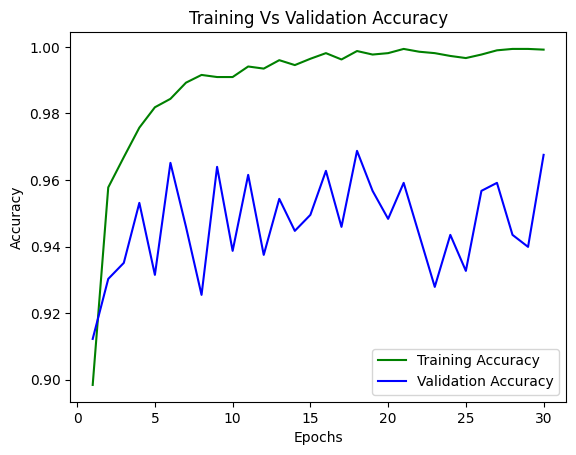

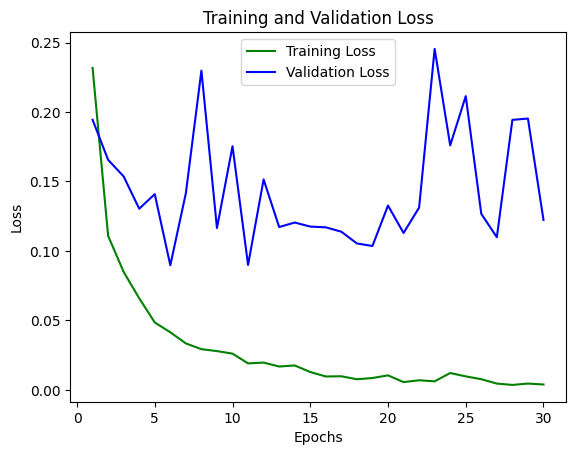

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array

# Define paths
real_dataset_dir = '/Users/muhammadalimiran/Desktop/Livenesss Detection/real_depthmap'
fake_dataset_dir = '/Users/muhammadalimiran/Desktop/Livenesss Detection/fake_depthmap'

# Other parameters
batch_size = 32
validation_split = 0.15  # Proportion of data to use for validation

# Load image file paths
real_images = [os.path.join(real_dataset_dir, img) for img in os.listdir(real_dataset_dir)]
fake_images = [os.path.join(fake_dataset_dir, img) for img in os.listdir(fake_dataset_dir)]

# Assign labels: 1 for real, 0 for fake
real_labels = [1] * len(real_images)
fake_labels = [0] * len(fake_images)

# Combine images and labels
all_images = real_images + fake_images
all_labels = real_labels + fake_labels

# Split dataset into train and validation sets
train_images, valid_images, train_labels, valid_labels = train_test_split(
    all_images, all_labels, test_size=validation_split, random_state=42, stratify=all_labels
)

# Data generator for loading images
def image_generator(image_paths, labels, batch_size, target_size):
    while True:
        batch_paths = np.random.choice(image_paths, size=batch_size)
        batch_images = []
        batch_labels = []
        for path in batch_paths:
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  # Convert and normalize
            batch_images.append(img_array)
            batch_labels.append(labels[image_paths.index(path)])
        yield np.array(batch_images), np.array(batch_labels)

# Model architecture
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet.trainable = False
output = Flatten()(mobilenet.output)
output = Dropout(0.3)(output)
output = Dense(units=8, activation='relu')(output)
prediction = Dense(1, activation='sigmoid')(output)
model = Model(inputs=mobilenet.input, outputs=prediction)
model.summary()

# Model compilation
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate as needed
    metrics=['accuracy']
)

# Model training
train_data_gen = image_generator(train_images, train_labels, batch_size, target_size=(224, 224))
valid_data_gen = image_generator(valid_images, valid_labels, batch_size, target_size=(224, 224))

history = model.fit(
    train_data_gen,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=30,
    verbose=1,
    validation_data=valid_data_gen,
    validation_steps=len(valid_images) // batch_size
)

# Plot training and validation accuracy
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, 31)
plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 1s 544ms/step


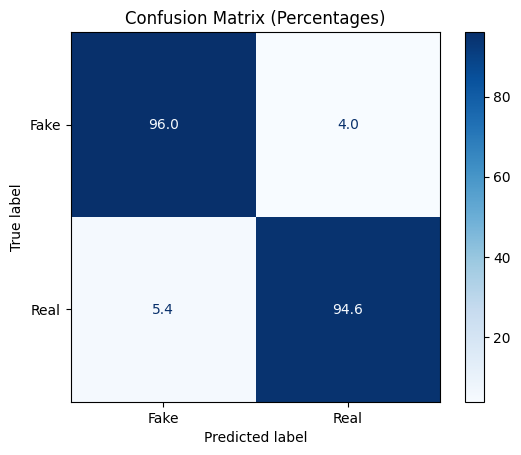

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define batch size for processing the validation set
batch_size_val = 32

# Calculate the number of steps needed to process the validation set in batches
steps_per_epoch_val = len(valid_images) // batch_size_val

# Initialize variables for accumulating predictions and true labels
y_pred_all = []
y_true_all = []

# Iterate through batches of the validation set
for _ in range(steps_per_epoch_val):
    batch_images, batch_labels = next(valid_data_gen)
    batch_predictions = model.predict(batch_images)
    y_pred_all.extend(batch_predictions)
    y_true_all.extend(batch_labels)

# Convert probabilities to binary predictions
y_pred_all = (np.array(y_pred_all) > 0.5).astype(int)

# Create a confusion matrix
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

# Plot confusion matrix with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues, values_format='.1f')  # Display percentages with one decimal place
plt.title('Confusion Matrix (Percentages)')
plt.show()